# Project: Minimum Cost Flow 
### An Implementation of the Successive Shortest Path Algorithm

**1. Graph Definition**
Let $G = (V, E)$ be a directed graph where $V$ is the set of vertices and $E$ is the set of edges.
We distinguish two special nodes:
* **Source ($s$):** The node where flow originates.
* **Sink ($t$):** The node where flow terminates.

**2. Edge Constraints**
For every edge $(u, v) \in E$, we define:
* **Capacity ($C_{uv}$):** The maximum flow allowed on the edge. $0 \le f_{uv} \le C_{uv}$.
* **Cost ($W_{uv}$):** The cost incurred per unit of flow.

**3. The Optimization Objective**
We aim to push a flow of magnitude $F$ from $s \to t$ while minimizing the total cost:
$$\text{Minimize } \sum_{(u,v) \in E} f_{uv} \cdot W_{uv}$$

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

## The Problem: Minimum Cost Flow

**What is it?**
Basically, this problem asks us to transfer a specific **amount** of "stuff" (flow) from a starting point (**Source**) to an ending point (**Sink**) through a network of connections (**Edges**).

**The Challenge**
We cannot just pick any path. Every edge has two rules:
1.  **Capacity:** The maximum amount it can handle at once.
2.  **Cost (Price):** The price we must pay to send one unit through that edge.

**The Goal**
We need to find the specific route that delivers the required amount while resulting in the **lowest possible total price**. We prioritize the "cheapest" edges first, but once they fill up (reach capacity), we are forced to use more expensive ones.

In [29]:
G = nx.DiGraph()

#Edges (start, End, Capacity, Cost)
edges = [
    ('S', 'A', 4, 1), # Top Path: Capacity 4, Cost $1
    ('S', 'B', 5, 5), # Bottom Path: Capacity 2, Cost $5
    ('A', 'B', 2, 1), # Connector: Capacity 2, Cost $1
    ('A', 'T', 3, 6), # Top to Sink: Cost $6
    ('B', 'T', 3, 1) # Bottom to Sink: Cost $1
]

for u, v, cap, cost in edges:
    # We initialize 'flow' to 0 for every edge
    G.add_edge(u, v, capacity=cap, weight=cost, flow=0)

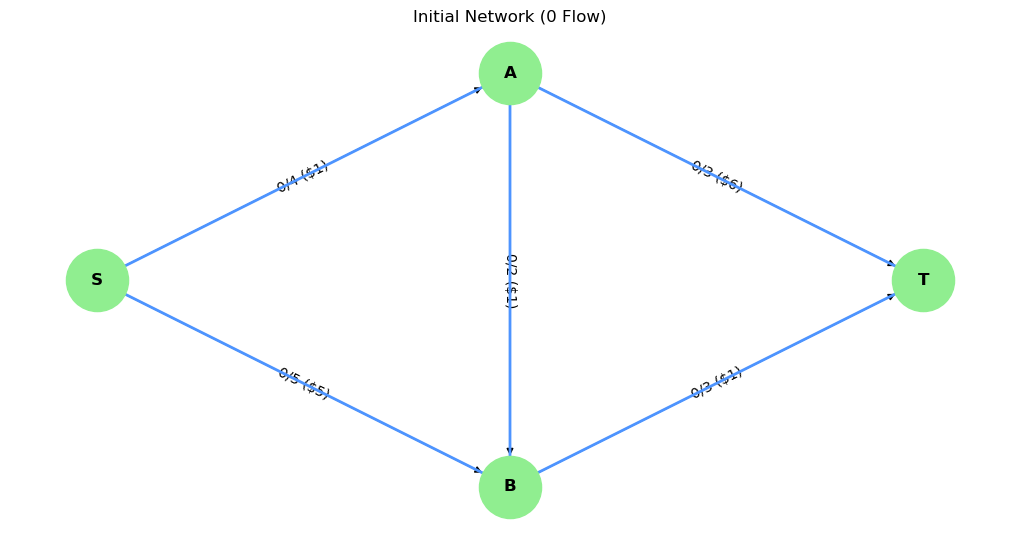

In [30]:
def draw_network(G, title = 'Current Flow State'):
    pos = {
        'S': (0, 1),
        'A': (1, 2),
        'B': (1, 0),
        'T': (2, 1)
    }

    #Labels and colours for edges
    edge_labels = {}
    edge_colors = []


#G.edges(data =True) returns a list of tuples, one for each edge: (Start_Node, End_Node, Attribute_Dictionary)
# Ex: ('S', 'A', {'capacity': 4, 'weight': 1, 'flow': 0})
    
    for u, v, d in G.edges(data=True):              
        label = f"{d['flow']}/{d['capacity']} (${d['weight']})"
        edge_labels[(u, v)] = label
        
        # Color edges RED if they are full (Flow == Capacity)
        if d['flow'] >= d['capacity']:
            edge_colors.append('#ff4d4d') # Red
        else:
            edge_colors.append('#4d94ff') # Blue

    plt.figure(figsize=(10, 5))
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, arrowsize=20)
    plt.title(title)
    plt.show()


draw_network(G, "Initial Network (0 Flow)")



## The Algorithm (The Logic)
**Method:** Successive Shortest Path Algorithm (Iterative & "Greedy")

1.  **Find the Cheapest Path**
    * We use `nx.shortest_path` with `weight='weight'`.
    * *Why?* This forces the algorithm to choose the path with the **lowest total cost**, rather than just the fewest number of stops.

2.  **Calculate the Bottleneck**
    * We loop through the selected path to find the "weakest link."
    * The bottleneck is the **minimum remaining capacity** of any pipe along that route.

3.  **Push Flow**
    * We send the maximum amount of flow allowed by the bottleneck.
    * We update the graph to reflect the new used capacity.

4.  **Repeat**
    * We repeat these steps on the updated graph until the total target is reached.

In [31]:
def solve_min_cost_flow_residual(G, source, sink, target_flow):
    current_flow = 0
    total_cost = 0
    
    # Draw the initial state (0 flow)
    draw_network(G, f"Start: Flow 0 | Cost $0")
    
    print(f"--- Algorithm Started: Target Flow = {target_flow} ---\n")
    
    while current_flow < target_flow:
        # 1. Create the Residual Graph
        R = nx.DiGraph()
        
        for u, v, d in G.edges(data=True):
            # Forward Edge
            remaining_cap = d['capacity'] - d['flow']
            if remaining_cap > 0:
                R.add_edge(u, v, weight=d['weight'], capacity=remaining_cap, type='forward')
            
            # Backward Edge
            if d['flow'] > 0:
                R.add_edge(v, u, weight=-d['weight'], capacity=d['flow'], type='backward')

        try:
            # 2. Bellman-Ford Path
            path = nx.bellman_ford_path(R, source, sink, weight='weight')
        except nx.NetworkXNoPath:
            print("(!) Network is Saturated. Cannot push more flow.")
            break

        # 3. Calculate Bottleneck
        path_bottleneck = float('inf')
        for i in range(len(path)-1):
            u_next, v_next = path[i], path[i+1]
            room = R[u_next][v_next]['capacity']
            path_bottleneck = min(path_bottleneck, room)
            
        # Determine flow to push
        flow_to_push = min(path_bottleneck, target_flow - current_flow)
        
        path_cost = nx.path_weight(R, path, 'weight')
        print(f"Path: {path} | Cost: ${path_cost}/unit | Pushing: {flow_to_push}")
        
        # 4. Update the Real Graph G
        for i in range(len(path)-1):
            u_r, v_r = path[i], path[i+1]
            edge_type = R[u_r][v_r]['type']
            
            if edge_type == 'forward':
                G[u_r][v_r]['flow'] += flow_to_push
                total_cost += flow_to_push * G[u_r][v_r]['weight']
            else:
                G[v_r][u_r]['flow'] -= flow_to_push
                total_cost -= flow_to_push * G[v_r][u_r]['weight']
                
        current_flow += flow_to_push
        
        
        draw_network(G, f"Flow: {current_flow} | Total Cost: ${total_cost}")
        
    return current_flow, total_cost

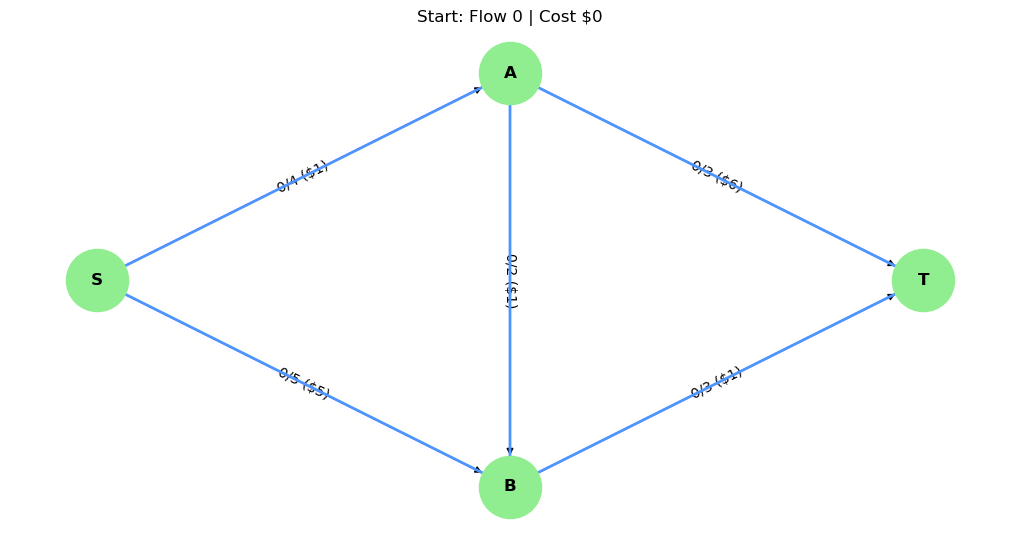

--- Algorithm Started: Target Flow = 6 ---

Path: ['S', 'A', 'B', 'T'] | Cost: $3/unit | Pushing: 2


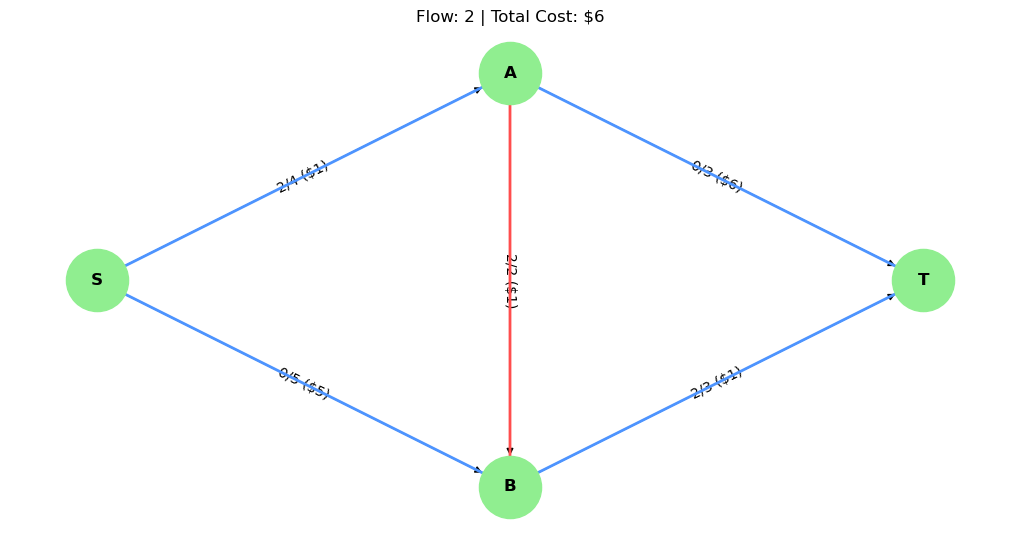

Path: ['S', 'B', 'T'] | Cost: $6/unit | Pushing: 1


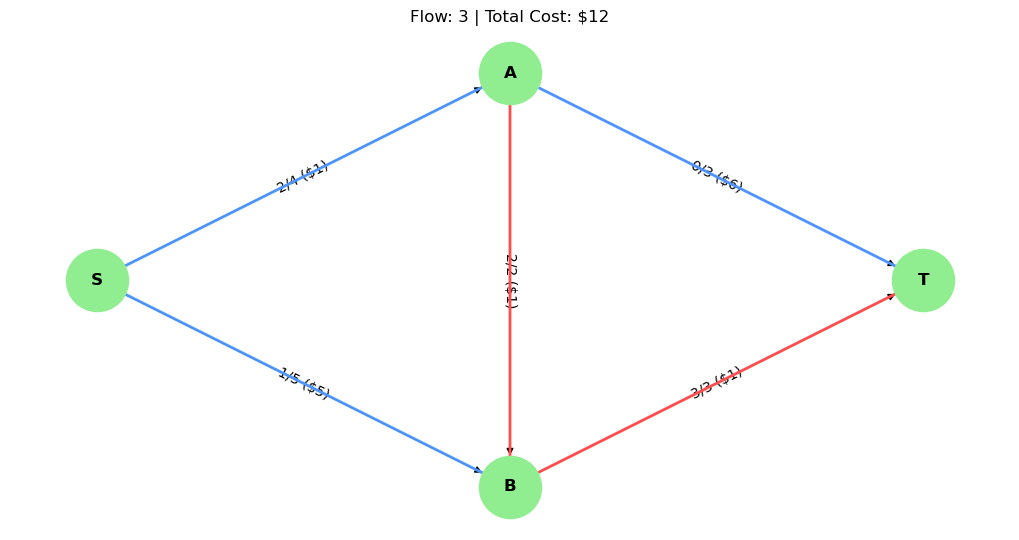

Path: ['S', 'A', 'T'] | Cost: $7/unit | Pushing: 2


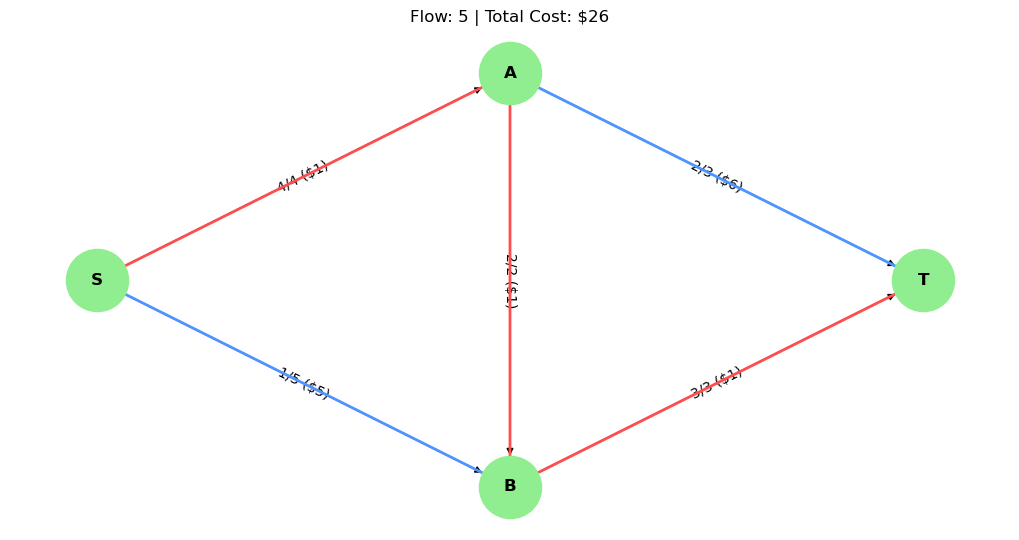

Path: ['S', 'B', 'A', 'T'] | Cost: $10/unit | Pushing: 1


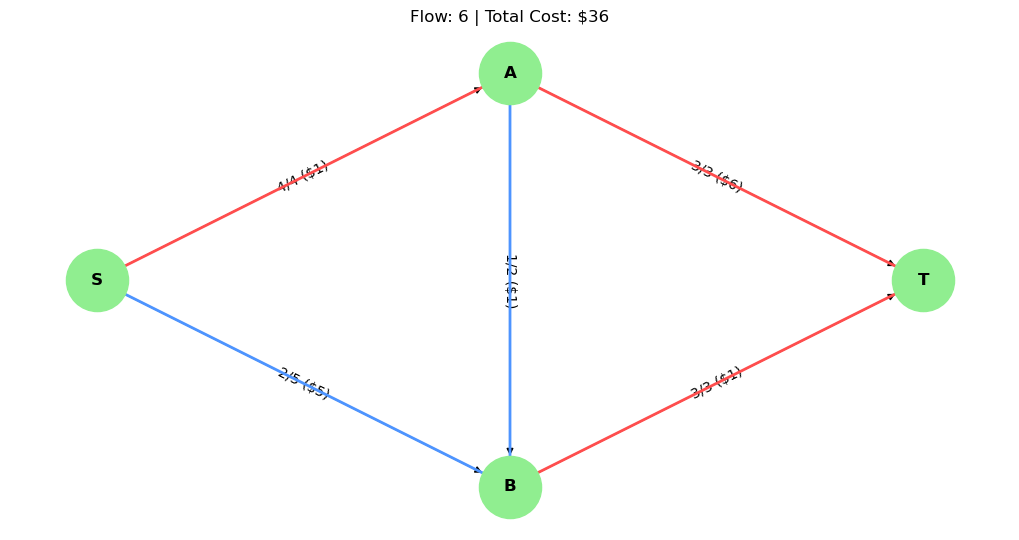

------------------------------
FINAL RESULTS
------------------------------
Target: 6
Moved:  6
Cost:   $36


In [32]:
# Reset flows just in case
for u, v in G.edges():
    G[u][v]['flow'] = 0

k_flow = 6


final_flow, final_cost = solve_min_cost_flow_residual(G, 'S', 'T', k_flow)

print("-" * 30)
print(f"FINAL RESULTS")
print("-" * 30)
print(f"Target: {k_flow}")
print(f"Moved:  {final_flow}")
print(f"Cost:   ${final_cost}")